# Building emission clusters based only on the Energy Sector

In [2]:
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

Shape after NUTS2 cleaning: (7722, 8)
Example regions: ['AT11' 'AT12' 'AT13' 'AT21' 'AT22' 'AT31' 'AT32' 'AT33' 'AT34' 'BE10']
Baseline years: [1990 1991 1992 1993 1994]
Recent years: [2018 2019 2020 2021 2022]
Regions available for clustering: 234
K-means fitted with k = 4

Centroids (unscaled):
   co2_baseline_mean  co2_recent_mean  co2_abs_change  co2_rel_change  cluster
0           1898.499         1903.401           4.902           1.248        0
1          30408.287        18729.168      -11679.119          -0.376        1
2          10619.471         5105.861       -5513.610          -0.545        2
3              1.347          579.512         578.165         337.528        3

Cluster name map: {3: 'Post-Carbon Regime', 1: 'Carbon-Intensive Legacy Regime', 2: 'Transitioning Carbon Regime', 0: 'Persistent Carbon Regime'}

=== df_features.head() ===
  region  co2_baseline_mean  co2_recent_mean  co2_abs_change  co2_rel_change  \
0   AT11         276.552916       334.341150       5

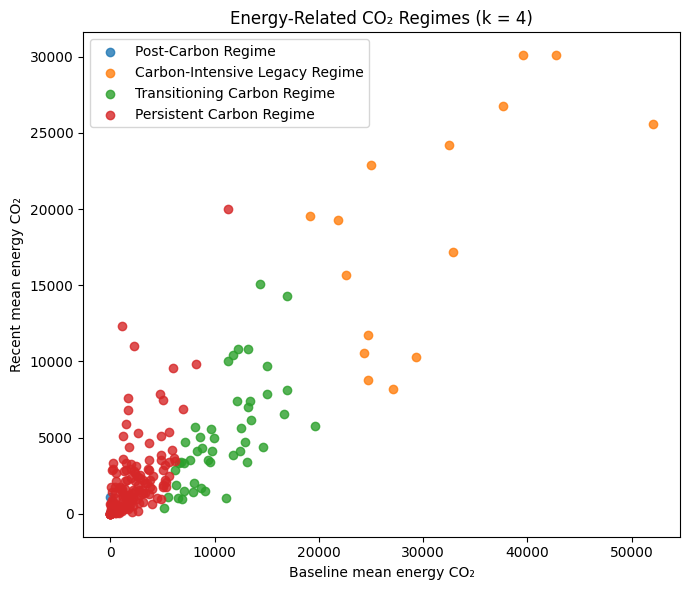

In [3]:
df = pd.read_csv("Emissions_NUTS2.csv")


df_energy = df.copy()

df_energy = df_energy[
    (df_energy["Substance"] == "CO2") &
    (df_energy["Sector"] == "Energy")
].copy()

# Renaming
df_energy = df_energy.rename(
    columns={
        "NUTS 2": "region",     # NUTS2 / NUTS0 codes
        "Year": "year",
        "Emissions": "co2_energy"
    }
)

# Ensure types
df_energy["region"] = df_energy["region"].astype(str)
df_energy["year"] = df_energy["year"].astype(int)
df_energy["co2_energy"] = pd.to_numeric(df_energy["co2_energy"], errors="coerce")

# ==========================================================
# 1. CLEAN: DROP NUTS0 CODES AND NON-NUTS2 CODES
# ==========================================================

invalid_regions = [
    "AT","BE","BG","DE","DK","EE","EL","ES","FI","FR","GF","GP","HR","HU",
    "IE","IT","LT","LU","LV","MQ","NL","PL","PT","RE","RO","SE","SI"
]

# 1.1 Drop country-level (NUTS0) codes
df_energy = df_energy[~df_energy["region"].isin(invalid_regions)].copy()

# 1.2 Drop Excel/date-like codes such as "Dec-00"
df_energy = df_energy[~df_energy["region"].str.contains(r"-\d\d", na=False)].copy()

# 1.3 Keep only codes that look like proper NUTS2: two letters + two alphanumerics
def is_nuts2(code: str) -> bool:
    return bool(re.match(r"^[A-Z]{2}[0-9A-Z]{2}$", str(code)))

df_energy["is_nuts2"] = df_energy["region"].apply(is_nuts2)
df_energy = df_energy[df_energy["is_nuts2"]].drop(columns=["is_nuts2"])

print("Shape after NUTS2 cleaning:", df_energy.shape)
print("Example regions:", df_energy["region"].unique()[:10])

# ==========================================================
# 2. BUILD ENERGY-ONLY FEATURES (BASELINE / RECENT / CHANGES)
# ==========================================================

years = np.sort(df_energy["year"].unique())
if len(years) == 0:
    raise ValueError("No years found after filtering to Energy sector.")

min_year, max_year = years[0], years[-1]
baseline_years = years[:min(5, len(years))]
recent_years   = years[-min(5, len(years)):]

print("Baseline years:", baseline_years)
print("Recent years:",   recent_years)

# Aggregate by region–year first
agg = (
    df_energy
    .groupby(["region", "year"], as_index=False)["co2_energy"]
    .mean()
)

# Baseline mean per region
baseline = (
    agg[agg["year"].isin(baseline_years)]
    .groupby("region")["co2_energy"]
    .mean()
    .rename("co2_baseline_mean")
)

# Recent mean per region
recent = (
    agg[agg["year"].isin(recent_years)]
    .groupby("region")["co2_energy"]
    .mean()
    .rename("co2_recent_mean")
)

# Merge into features table
df_features = (
    pd.concat([baseline, recent], axis=1)
    .dropna(subset=["co2_baseline_mean", "co2_recent_mean"])
    .reset_index()
)

# Changes
df_features["co2_abs_change"] = (
    df_features["co2_recent_mean"] - df_features["co2_baseline_mean"]
)

df_features["co2_rel_change"] = np.where(
    df_features["co2_baseline_mean"] > 0,
    df_features["co2_abs_change"] / df_features["co2_baseline_mean"],
    np.nan
)

# Drop regions with undefined relative change
df_features = df_features.dropna(subset=["co2_rel_change"])

feature_cols = [
    "co2_baseline_mean",
    "co2_recent_mean",
    "co2_abs_change",
    "co2_rel_change"
]

print("Regions available for clustering:", df_features.shape[0])

# ==========================================================
# 3. K-MEANS CLUSTERING (k = 4) ON ENERGY FEATURES
# ==========================================================

X = df_features[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_final = 4
kmeans = KMeans(n_clusters=k_final, n_init=20, random_state=42)
df_features["cluster"] = kmeans.fit_predict(X_scaled)

print("K-means fitted with k =", k_final)

# ==========================================================
# 4. CENTROIDS IN ORIGINAL UNITS + REGIME NAMING
# ==========================================================

centroids_unscaled = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=feature_cols
)
centroids_unscaled["cluster"] = centroids_unscaled.index

print("\nCentroids (unscaled):")
print(centroids_unscaled.round(3))

# ---- Programmatic regime naming ----
cluster_name_map = {}
tmp = centroids_unscaled.copy()

recent = tmp["co2_recent_mean"]
abs_ch = tmp["co2_abs_change"]
median_recent = recent.median()
assigned = set()

# Post-Carbon: low recent & non-positive change
post_candidates = tmp[(recent <= median_recent) & (abs_ch <= 0)]
if not post_candidates.empty:
    idx_post = post_candidates["co2_recent_mean"].idxmin()
else:
    idx_post = recent.idxmin()

c_post = int(tmp.loc[idx_post, "cluster"])
cluster_name_map[c_post] = "Post-Carbon Regime"
assigned.add(c_post)

# Reinforced: high recent & positive change
remaining = tmp[~tmp["cluster"].isin(assigned)]
high_em = remaining[remaining["co2_recent_mean"] >= median_recent]

if not high_em.empty:
    pos = high_em[high_em["co2_abs_change"] > 0]
    if not pos.empty:
        idx_reinf = pos["co2_abs_change"].idxmax()
    else:
        idx_reinf = high_em["co2_recent_mean"].idxmax()
    c_reinf = int(tmp.loc[idx_reinf, "cluster"])
    cluster_name_map[c_reinf] = "Carbon-Intensive Legacy Regime" 
    assigned.add(c_reinf)

# Stabilized: high recent, change closest to 0
remaining = tmp[~tmp["cluster"].isin(assigned)]
high_em = remaining[remaining["co2_recent_mean"] >= median_recent]

if not high_em.empty:
    idx_stab = high_em["co2_abs_change"].abs().idxmin()
    c_stab = int(tmp.loc[idx_stab, "cluster"])
    cluster_name_map[c_stab] = "Transitioning Carbon Regime"
    assigned.add(c_stab)

# Destabilizing: whatever remains
remaining = tmp[~tmp["cluster"].isin(assigned)]
for c in remaining["cluster"]:
    cluster_name_map[int(c)] = "Persistent Carbon Regime"

print("\nCluster name map:", cluster_name_map)

df_features["cluster_name"] = df_features["cluster"].map(cluster_name_map)

# Attach names to centroids table as well
centroids_unscaled["cluster_name"] = centroids_unscaled["cluster"].map(cluster_name_map)

# ==========================================================
# 5. OUTPUT & SIMPLE PLOT
# ==========================================================

print("\n=== df_features.head() ===")
print(df_features[["region"] + feature_cols + ["cluster", "cluster_name"]].head())

print("\n=== Centroids with regime names ===")
print(centroids_unscaled.round(3))

# Visual check: baseline vs recent, colored by regime
plt.figure(figsize=(7, 6))
for cl, name in cluster_name_map.items():
    s = df_features[df_features["cluster"] == cl]
    plt.scatter(
        s["co2_baseline_mean"], s["co2_recent_mean"],
        alpha=0.8, label=name
    )

plt.xlabel("Baseline mean energy CO₂")
plt.ylabel("Recent mean energy CO₂")
plt.title("Energy-Related CO₂ Regimes (k = 4)")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# Creating the file for map vizualization


# 1. Make a copy so we don't accidentally modify df_features
df_export = df_features.copy()

# 2. Create a standard NUTS ID column name for joining in Tableau
#    (many NUTS shapefiles use NUTS_ID or NUTS_2 as key)
df_export["NUTS_ID"] = df_export["region"]

# 3. Choose and order the columns you want in Tableau
cols_order = [
    "NUTS_ID",               # join key for the map
    "cluster",               # numeric cluster ID (0–3)
    "cluster_name",          # regime label
    "co2_baseline_mean",     # optional: for tooltips / analysis
    "co2_recent_mean",
    "co2_abs_change",
    "co2_rel_change",
]

df_export = df_export[cols_order].sort_values("NUTS_ID")

# 4. Save to CSV for Tableau
output_path = "NUTS2_energy_CO2_regimes.csv"   # change path if you want
df_export.to_csv(output_path, index=False, float_format="%.3f", encoding="utf-8")

print(f"Exported {df_export.shape[0]} regions to: {output_path}")


Exported 234 regions to: NUTS2_energy_CO2_regimes.csv


In [5]:
# Checking if we lost any regions on the way
print("TOTAL regions before any filtering: ", df["NUTS 2"].nunique())

# After filtering to energy
df_energy = df[(df["Substance"] == "CO2") & (df["Sector"] == "Energy")]
print("After filtering to energy sector: ", df_energy["NUTS 2"].nunique())

# After NUTS0 removal
df_no_nuts0 = df_energy[~df_energy["NUTS 2"].isin(invalid_regions)]
print("After removing NUTS0 codes: ", df_no_nuts0["NUTS 2"].nunique())

# After regex filtering
df_regex = df_no_nuts0[df_no_nuts0["NUTS 2"].str.match(r'^[A-Z]{2}[0-9A-Z]{2}$')]
print("After regex NUTS2 filter: ", df_regex["NUTS 2"].nunique())

# After baseline/recent merge
print("Regions with baseline data: ", df_regex[df_regex["year"].isin(baseline_years)]["NUTS 2"].nunique())
print("Regions with recent data:   ", df_regex[df_regex["year"].isin(recent_years)]["NUTS 2"].nunique())

# Regions that appear in BOTH periods
baseline_regions = set(df_regex[df_regex["year"].isin(baseline_years)]["NUTS 2"])
recent_regions   = set(df_regex[df_regex["year"].isin(recent_years)]["NUTS 2"])
overlap = baseline_regions & recent_regions

print("Regions present in BOTH periods: ", len(overlap))

# After feature table construction
print("Regions in df_features final:", df_features["region"].nunique())


TOTAL regions before any filtering:  273
After filtering to energy sector:  234
After removing NUTS0 codes:  234
After regex NUTS2 filter:  234


KeyError: 'year'

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
# ---------------------------------------------------
# 0. Prepare data (reuse the features you clustered on)
# ---------------------------------------------------
feature_cols = [
    "co2_baseline_mean",
    "co2_recent_mean",
    "co2_abs_change",
    "co2_rel_change",
]

X = df_features[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_final = 4  # your chosen number of clusters

# Fit a "reference" k-means model
kmeans_ref = KMeans(
    n_clusters=k_final,
    n_init=50,
    random_state=42
)
labels_ref = kmeans_ref.fit_predict(X_scaled)

df_features["cluster_ref"] = labels_ref  # keep this if you want


# ===================================================
# 1A. Stability under different random initialisations
# ===================================================

n_runs = 50
aris_reinit = []

for seed in range(n_runs):
    km = KMeans(
        n_clusters=k_final,
        n_init=10,
        random_state=seed
    )
    labels = km.fit_predict(X_scaled)
    ari = adjusted_rand_score(labels_ref, labels)
    aris_reinit.append(ari)

print("Re-initialisation stability (ARI vs reference):")
print(f"  Mean ARI:  {np.mean(aris_reinit):.3f}")
print(f"  Median ARI:{np.median(aris_reinit):.3f}")
print(f"  Min–Max:   {np.min(aris_reinit):.3f} – {np.max(aris_reinit):.3f}")

# Rule-of-thumb:
# ARI > 0.9  → extremely stable
# 0.7–0.9    → reasonably stable
# < 0.7      → more sensitive / fragile clustering


# ===============================================
# 1B. Noise robustness: add small Gaussian noise
# ===============================================

n_runs_noise = 50
noise_std = 0.05  # 5% of std (since scaled data has std≈1)

aris_noise = []

for i in range(n_runs_noise):
    noise = np.random.normal(loc=0, scale=noise_std, size=X_scaled.shape)
    X_noisy = X_scaled + noise

    km = KMeans(
        n_clusters=k_final,
        n_init=10,
        random_state=42
    )
    labels = km.fit_predict(X_noisy)
    ari = adjusted_rand_score(labels_ref, labels)
    aris_noise.append(ari)

print("\nNoise robustness (ARI vs reference, 5% noise):")
print(f"  Mean ARI:  {np.mean(aris_noise):.3f}")
print(f"  Median ARI:{np.median(aris_noise):.3f}")
print(f"  Min–Max:   {np.min(aris_noise):.3f} – {np.max(aris_noise):.3f}")


# ===============================================
# 1C. Bootstrap stability: resample regions
# ===============================================

n_boot = 50
sample_frac = 0.8   # 80% of regions each time
aris_boot = []

N = X_scaled.shape[0]
indices = np.arange(N)

for i in range(n_boot):
    # sample indices without replacement
    sample_idx = np.random.choice(indices, size=int(sample_frac * N), replace=False)

    X_boot = X_scaled[sample_idx, :]
    labels_ref_boot = labels_ref[sample_idx]

    km = KMeans(
        n_clusters=k_final,
        n_init=10,
        random_state=42
    )
    labels_boot = km.fit_predict(X_boot)

    ari = adjusted_rand_score(labels_ref_boot, labels_boot)
    aris_boot.append(ari)

print("\nBootstrap stability (ARI on 80% subsamples):")
print(f"  Mean ARI:  {np.mean(aris_boot):.3f}")
print(f"  Median ARI:{np.median(aris_boot):.3f}")
print(f"  Min–Max:   {np.min(aris_boot):.3f} – {np.max(aris_boot):.3f}")

Re-initialisation stability (ARI vs reference):
  Mean ARI:  0.951
  Median ARI:0.963
  Min–Max:   0.741 – 1.000

Noise robustness (ARI vs reference, 5% noise):
  Mean ARI:  0.922
  Median ARI:0.947
  Min–Max:   0.727 – 0.996

Bootstrap stability (ARI on 80% subsamples):
  Mean ARI:  0.896
  Median ARI:0.920
  Min–Max:   0.684 – 1.000


## Updating the clustering

In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ===============================
# 0. LOAD AND FILTER ENERGY DATA
# ===============================

df = pd.read_csv("Emissions_NUTS2.csv")
df.columns = df.columns.str.strip()

print("Columns:", df.columns.tolist())

required_cols = ["Substance", "ISO", "Country", "NUTS 2", "NUTS 2 desc", "Sector", "Year", "Emissions"]
assert all(col in df.columns for col in required_cols), "Column names differ—check dataset."

# Ensure types
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Emissions"] = pd.to_numeric(df["Emissions"], errors="coerce")

# IMPORTANT:
# Your sample shows sectors like "Dom_Avi". That is NOT "Energy".
# Replace this set with the exact sector codes in your dataset that represent energy supply/production.
ENERGY_SECTORS = {"Energy"}  # <-- CHANGE THIS

df_energy = df[
    (df["Substance"] == "CO2") &
    (df["Sector"].isin(ENERGY_SECTORS))
].copy()

# Rename emissions to a working column
df_energy = df_energy.rename(columns={"Emissions": "co2_energy"})

print("Energy dataframe shape:", df_energy.shape)
print("Years present:", sorted(df_energy["Year"].dropna().unique()))
print("Energy sectors present:", sorted(df_energy["Sector"].dropna().unique())[:50])

# ===================================
# 1. FOCUS ON RECENT TRANSITION PERIOD
# ===================================

MIN_YEAR = 2008
df_recent = df_energy[df_energy["Year"] >= MIN_YEAR].copy()
print("Filtered years:", sorted(df_recent["Year"].dropna().unique()))

years = np.sort(df_recent["Year"].dropna().unique())
if len(years) < 2:
    raise ValueError("Not enough years after MIN_YEAR to compute baseline/recent windows.")

n_sub = min(5, len(years))
baseline_years = years[:n_sub]
recent_years   = years[-n_sub:]

print("Baseline years:", baseline_years)
print("Recent years:", recent_years)

# ================================
# 2. COMPUTE BASELINE/RECENT MEANS
# ================================

# Sum to region-year totals (in case you have multiple energy subsectors per region-year)
agg = (
    df_recent
    .groupby(["NUTS 2", "Year"], as_index=False)["co2_energy"]
    .sum()
)

baseline = (
    agg[agg["Year"].isin(baseline_years)]
    .groupby("NUTS 2")["co2_energy"]
    .mean()
    .rename("co2_baseline_mean")
)

recent = (
    agg[agg["Year"].isin(recent_years)]
    .groupby("NUTS 2")["co2_energy"]
    .mean()
    .rename("co2_recent_mean")
)

df_features = pd.concat([baseline, recent], axis=1).dropna().reset_index()

df_features["co2_abs_change"] = df_features["co2_recent_mean"] - df_features["co2_baseline_mean"]
df_features["co2_rel_change"] = np.where(
    df_features["co2_baseline_mean"] != 0,
    df_features["co2_abs_change"] / df_features["co2_baseline_mean"],
    np.nan
)

df_features = df_features.dropna(subset=["co2_rel_change"]).copy()

print("df_features shape:", df_features.shape)
print(df_features.head())

# ==========================
# 3. K-MEANS + SILHOUETTE
# ==========================

# Use the same idea: level + change
X = df_features[["co2_baseline_mean", "co2_rel_change"]].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n = X_scaled.shape[0]
if n < 3:
    raise ValueError("Need at least 3 regions to run silhouette testing.")

k_min = 2
k_max = min(10, n - 1)

sil_scores = []
inertias = []

print("\nSilhouette test (higher is better):")
for k in range(k_min, k_max + 1):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    sil_scores.append((k, sil))
    inertias.append((k, km.inertia_))

    print(f"  k={k:2d}  silhouette={sil:.4f}  inertia={km.inertia_:.2f}")


Columns: ['Substance', 'ISO', 'Country', 'NUTS 2', 'NUTS 2 desc', 'Sector', 'Year', 'Emissions']
Energy dataframe shape: (7722, 8)
Years present: [np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Energy sectors present: ['Energy']
Filtered years: [np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Baseline years: [2008 2009 2010 2

### K-means clustering on the new data (2008 onwards)


Cluster centers (original scale):
   co2_baseline_mean  co2_rel_change  cluster_id
0         5105.91477       -0.192722           0
1            3.27308      332.376024           1

Cluster naming map:
  cluster_id=0: High-Legacy Managed Decline Regime
  cluster_id=1: Low-Legacy Stable / Marginal-Change Regime

Cluster summary:
                                                      co2_baseline_mean  \
                                                                   mean   
cluster_id cluster_name                                                   
0          High-Legacy Managed Decline Regime                5105.91477   
1          Low-Legacy Stable / Marginal-Change Regime           3.27308   

                                                                          \
                                                            median count   
cluster_id cluster_name                                                    
0          High-Legacy Managed Decline Regime          2585.62841

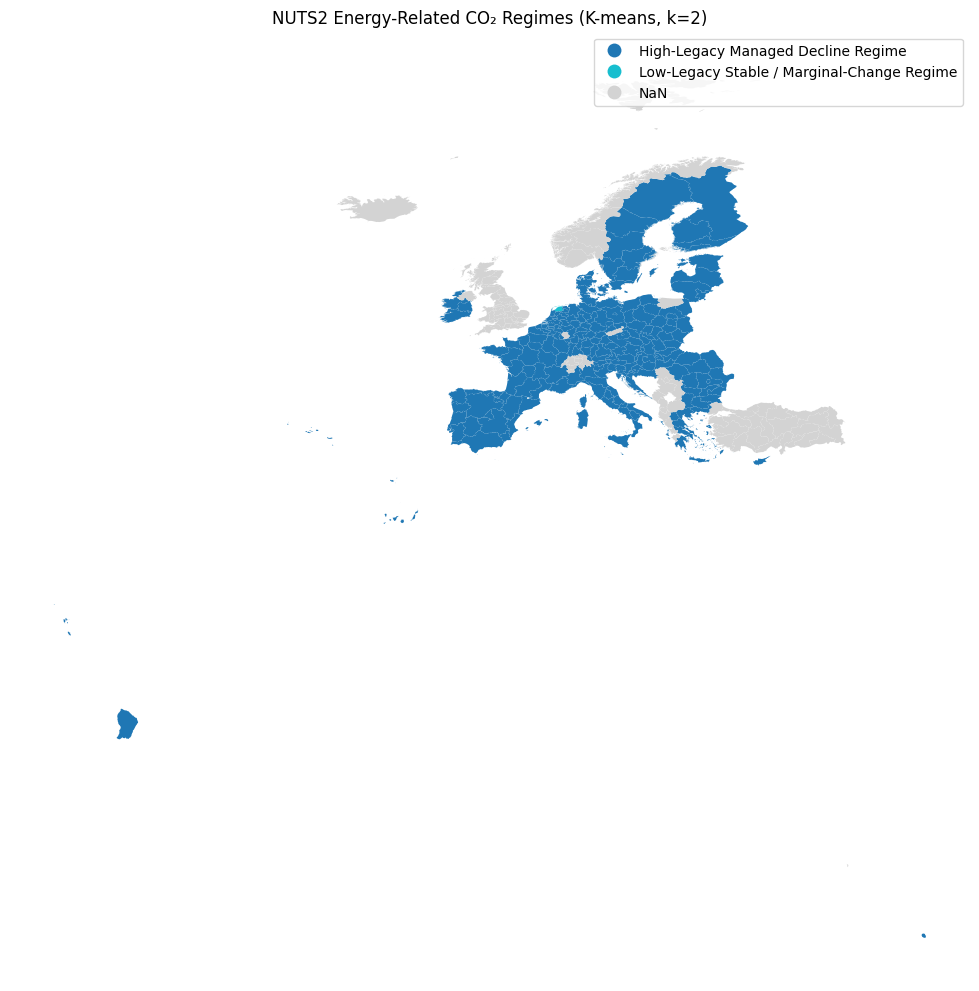

Saved: energy_co2_clusters_map.png


In [9]:
# ===============================
# 5) K-MEANS (k=2) + CENTERS
# ===============================
X = df_features[["co2_baseline_mean", "co2_rel_change"]].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

K_FINAL = 2
kmeans = KMeans(n_clusters=K_FINAL, random_state=42, n_init=20)
df_features["cluster_id"] = kmeans.fit_predict(X_scaled)

# centers back to original scale
centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers, columns=["co2_baseline_mean", "co2_rel_change"])
centers_df["cluster_id"] = range(K_FINAL)

print("\nCluster centers (original scale):")
print(centers_df.sort_values("cluster_id"))

# ===============================
# 6) THEORY-ALIGNED PRECISE NAMING (DATA-DRIVEN)
# ===============================
# We name clusters based on their *centers*:
# - higher baseline = more "legacy carbon intensity" / infrastructural scale
# - higher (less negative) rel_change = weaker decarbonisation (more persistence)

# rank clusters by baseline level
centers_df = centers_df.sort_values("co2_baseline_mean").reset_index(drop=True)

low_id  = int(centers_df.loc[0, "cluster_id"])
high_id = int(centers_df.loc[1, "cluster_id"])

high_rel = float(centers_df.loc[centers_df["cluster_id"] == high_id, "co2_rel_change"].iloc[0])
low_rel  = float(centers_df.loc[centers_df["cluster_id"] == low_id,  "co2_rel_change"].iloc[0])

# precise regime names (two-regime structure, aligned with lock-in debate)
# If the high-baseline cluster also has weaker decline / increase, it's the lock-in regime.
if high_rel > low_rel:
    name_map = {
        high_id: "Reinforced Carbon Lock-In Regime",
        low_id:  "Declining / Break-Out Carbon Regime"
    }
else:
    # edge case: high baseline but stronger decline (managed disruption)
    name_map = {
        high_id: "High-Legacy Managed Decline Regime",
        low_id:  "Low-Legacy Stable / Marginal-Change Regime"
    }

df_features["cluster_name"] = df_features["cluster_id"].map(name_map)

print("\nCluster naming map:")
for k, v in name_map.items():
    print(f"  cluster_id={k}: {v}")

# quick summary
summary = (
    df_features
    .groupby(["cluster_id", "cluster_name"])[
        ["co2_baseline_mean", "co2_recent_mean", "co2_abs_change", "co2_rel_change"]
    ]
    .agg(["mean", "median", "count"])
)
print("\nCluster summary:")
print(summary)

# export cluster table
df_features.to_csv("energy_co2_features_clusters.csv", index=False)
print("\nSaved: energy_co2_features_clusters.csv")

# ===============================
# 7) MAP IN PYTHON (GeoPandas)
# ===============================
# NUTS shapefile structure
NUTS_ID_COL = "NUTS_ID"      # column with NUTS code
NUTS_LEVEL_COL = "LEVL_CODE" # column with NUTS level (0,1,2,3)
NUTS2_LEVEL_VALUE = 2        # we want NUTS-2

nuts = gpd.read_file("Spatial Data/NUTS_RG_01M_2021_4326.shp")

# Keep only NUTS2 if file contains multiple levels
if NUTS_LEVEL_COL in nuts.columns:
    nuts = nuts[nuts[NUTS_LEVEL_COL] == NUTS2_LEVEL_VALUE].copy()

# Ensure join key types align
nuts[NUTS_ID_COL] = nuts[NUTS_ID_COL].astype(str)
df_features["NUTS 2"] = df_features["NUTS 2"].astype(str)

gmap = nuts.merge(df_features, left_on=NUTS_ID_COL, right_on="NUTS 2", how="left")

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gmap.plot(column="cluster_name", ax=ax, legend=True, missing_kwds={"color": "lightgrey"})
ax.set_axis_off()
ax.set_title("NUTS2 Energy-Related CO₂ Regimes (K-means, k=2)")

plt.tight_layout()
plt.savefig("energy_co2_clusters_map.png", dpi=300)
plt.show()

print("Saved: energy_co2_clusters_map.png")

### Plotting the energy clusters

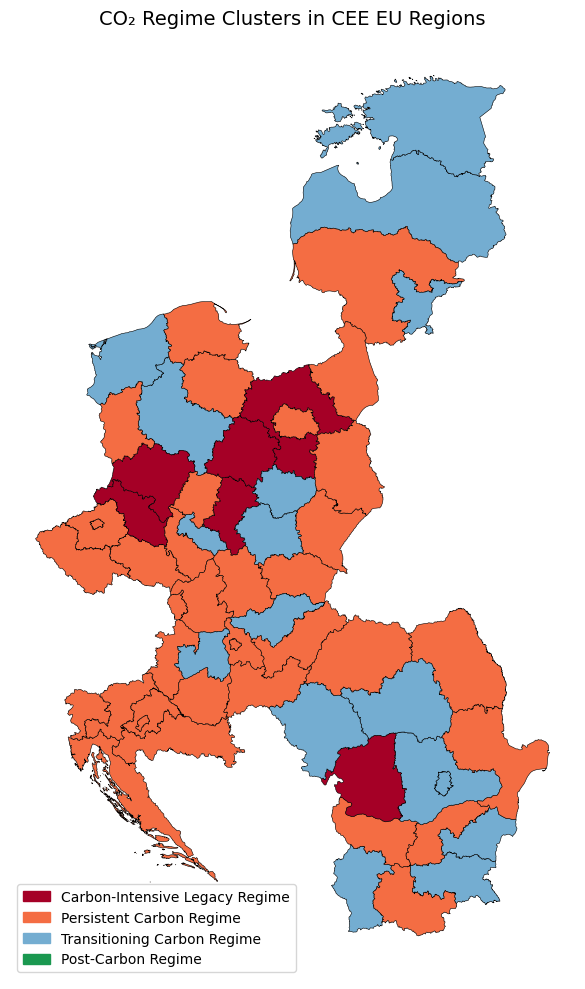

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Step 1: Load your clustering CSV ---
df_clusters = pd.read_csv("NUTS2_energy_CO2_regimes.csv")

# Ensure the key column is named 'NUTS_ID' for merge
df_clusters.rename(columns={"region": "NUTS_ID"}, inplace=True)

# --- Step 2: Load NUTS2 geometries from Eurostat (adjust path as needed) ---
# You should have downloaded the shapefile (NUTS 2021, 01M resolution) as described earlier
# Example path:
nuts_path = "Spatial Data/NUTS_RG_01M_2021_4326.shp"
gdf_nuts = gpd.read_file(nuts_path)

# Keep only NUTS2
gdf_nuts = gdf_nuts[gdf_nuts["LEVL_CODE"] == 2]
# --- Step 3: Filter to CEE EU countries ---
cee_countries = [
    "BG", "CZ", "EE", "HR", "HU", "LT", "LV",
    "PL", "RO", "SI", "SK"
]
gdf_nuts = gdf_nuts[gdf_nuts["CNTR_CODE"].isin(cee_countries)]

# --- Step 4: Merge with cluster data ---
gdf = gdf_nuts.merge(df_clusters, on="NUTS_ID", how="inner")

# --- Step 5: Assign colors to regimes ---
cluster_colors = {
    "Carbon-Intensive Legacy Regime": "#a50026",
    "Persistent Carbon Regime": "#f46d43",
    "Transitioning Carbon Regime": "#74add1",
    "Post-Carbon Regime": "#1a9850"
}
gdf["color"] = gdf["cluster_name"].map(cluster_colors)

# --- Step 6: Plot the map ---
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(color=gdf["color"], edgecolor="black", linewidth=0.4, ax=ax)

ax.set_title("CO₂ Regime Clusters in CEE EU Regions", fontsize=14)
ax.axis("off")

# Legend
patches = [mpatches.Patch(color=color, label=label) for label, color in cluster_colors.items()]
ax.legend(handles=patches, loc="lower left")

plt.tight_layout()
plt.show()


Shape after NUTS2 cleaning: (7722, 8)
Example regions: ['AT11' 'AT12' 'AT13' 'AT21' 'AT22' 'AT31' 'AT32' 'AT33' 'AT34' 'BE10']
Baseline years (fixed start): [2008 2009 2010 2011 2012]
Recent years: [2018 2019 2020 2021 2022]
Regions available for clustering: 234
K-means fitted with k = 4

Centroids (unscaled):
   co2_baseline_mean  co2_recent_mean  co2_abs_change  co2_rel_change  cluster
0          10606.920         7676.787       -2930.133          -0.306        0
1              3.273         1091.166        1087.893         332.376        1
2          31843.824        21369.096      -10474.728          -0.334        2
3           1839.858         1323.435        -516.423          -0.147        3

Cluster name map (unique, rank-based):
  cluster 0: High-Emission Slow Decline
  cluster 1: Low-Emission Marginal Decline
  cluster 2: High-Emission Rapid Decline
  cluster 3: Low-Emission Rapid Decline

Centroids with labels:
   cluster                   cluster_name  co2_baseline_mean  co2

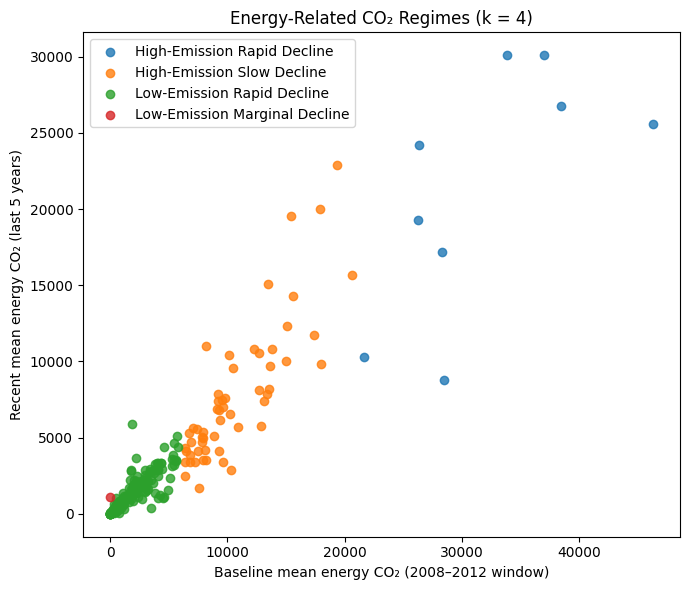

In [18]:
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ==========================================================
# 0. LOAD + FILTER ENERGY DATA
# ==========================================================

df = pd.read_csv("Emissions_NUTS2.csv")
df.columns = df.columns.str.strip()

df_energy = df.copy()

df_energy = df_energy[
    (df_energy["Substance"] == "CO2") &
    (df_energy["Sector"] == "Energy")
].copy()

# Renaming
df_energy = df_energy.rename(
    columns={
        "NUTS 2": "region",     # NUTS2 codes
        "Year": "year",
        "Emissions": "co2_energy"
    }
)

# Ensure types
df_energy["region"] = df_energy["region"].astype(str)
df_energy["year"] = pd.to_numeric(df_energy["year"], errors="coerce")
df_energy = df_energy.dropna(subset=["year"]).copy()
df_energy["year"] = df_energy["year"].astype(int)

df_energy["co2_energy"] = pd.to_numeric(df_energy["co2_energy"], errors="coerce")

# ==========================================================
# 1. CLEAN: DROP NUTS0 CODES AND NON-NUTS2 CODES
# ==========================================================

invalid_regions = [
    "AT","BE","BG","DE","DK","EE","EL","ES","FI","FR","GF","GP","HR","HU",
    "IE","IT","LT","LU","LV","MQ","NL","PL","PT","RE","RO","SE","SI"
]

# 1.1 Drop country-level (NUTS0) codes
df_energy = df_energy[~df_energy["region"].isin(invalid_regions)].copy()

# 1.2 Drop Excel/date-like codes such as "Dec-00"
df_energy = df_energy[~df_energy["region"].str.contains(r"-\d\d", na=False)].copy()

# 1.3 Keep only codes that look like proper NUTS2: two letters + two alphanumerics
def is_nuts2(code: str) -> bool:
    return bool(re.match(r"^[A-Z]{2}[0-9A-Z]{2}$", str(code)))

df_energy["is_nuts2"] = df_energy["region"].apply(is_nuts2)
df_energy = df_energy[df_energy["is_nuts2"]].drop(columns=["is_nuts2"])

print("Shape after NUTS2 cleaning:", df_energy.shape)
print("Example regions:", df_energy["region"].unique()[:10])

# ==========================================================
# 2. BUILD ENERGY-ONLY FEATURES (BASELINE / RECENT / CHANGES)
#    BASELINE WINDOW FORCED TO START AT 2008
# ==========================================================

baseline_start_year = 2008
baseline_len_years = 5
recent_len_years = 5

years = np.sort(df_energy["year"].unique())
if len(years) == 0:
    raise ValueError("No years found after filtering to Energy sector.")

max_year = years[-1]

# Baseline: 2008..2012 (or whatever subset exists in the data)
baseline_years = np.array([y for y in range(baseline_start_year, baseline_start_year + baseline_len_years)
                           if y in years])

if len(baseline_years) < 2:
    raise ValueError(
        f"Not enough baseline years found starting at {baseline_start_year}. "
        f"Found: {baseline_years}. Check whether your data contains 2008+."
    )

# Recent: last 5 years available in the dataset
recent_years = years[-min(recent_len_years, len(years)):]

print("Baseline years (fixed start):", baseline_years)
print("Recent years:", recent_years)

# Aggregate by region–year first
agg = (
    df_energy
    .groupby(["region", "year"], as_index=False)["co2_energy"]
    .mean()
)

# Baseline mean per region
baseline = (
    agg[agg["year"].isin(baseline_years)]
    .groupby("region")["co2_energy"]
    .mean()
    .rename("co2_baseline_mean")
)

# Recent mean per region
recent = (
    agg[agg["year"].isin(recent_years)]
    .groupby("region")["co2_energy"]
    .mean()
    .rename("co2_recent_mean")
)

# Merge into features table
df_features = (
    pd.concat([baseline, recent], axis=1)
    .dropna(subset=["co2_baseline_mean", "co2_recent_mean"])
    .reset_index()
)

# Changes
df_features["co2_abs_change"] = (
    df_features["co2_recent_mean"] - df_features["co2_baseline_mean"]
)

df_features["co2_rel_change"] = np.where(
    df_features["co2_baseline_mean"] > 0,
    df_features["co2_abs_change"] / df_features["co2_baseline_mean"],
    np.nan
)

# Drop regions with undefined relative change
df_features = df_features.dropna(subset=["co2_rel_change"])

feature_cols = [
    "co2_baseline_mean",
    "co2_recent_mean",
    "co2_abs_change",
    "co2_rel_change"
]

print("Regions available for clustering:", df_features.shape[0])

# ==========================================================
# 3. K-MEANS CLUSTERING (k = 4) ON ENERGY FEATURES
# ==========================================================

X = df_features[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_final = 4
kmeans = KMeans(n_clusters=k_final, n_init=20, random_state=42)
df_features["cluster"] = kmeans.fit_predict(X_scaled)

print("K-means fitted with k =", k_final)

# ==========================================================
# 4. CENTROIDS IN ORIGINAL UNITS + UNIQUE DECLINE-BASED LABELS
# ==========================================================

centroids_unscaled = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=feature_cols
)
centroids_unscaled["cluster"] = centroids_unscaled.index

print("\nCentroids (unscaled):")
print(centroids_unscaled.round(3))

tmp = centroids_unscaled.copy()

# 1) Split into High-Emission (top 2 by recent mean) vs Low-Emission (bottom 2)
tmp_sorted = tmp.sort_values("co2_recent_mean", ascending=False).reset_index(drop=True)

high_two = tmp_sorted.iloc[:2].copy()
low_two  = tmp_sorted.iloc[2:4].copy()

# Helper: in declining world, "rapid decline" = more negative rel change
def assign_pair_labels(df_pair, high=True):
    df_pair = df_pair.sort_values("co2_rel_change", ascending=True).copy()  # most negative first
    # df_pair.iloc[0] is faster decline, df_pair.iloc[1] is slower (or marginal) decline
    if high:
        return {
            int(df_pair.iloc[0]["cluster"]): "High-Emission Rapid Decline",
            int(df_pair.iloc[1]["cluster"]): "High-Emission Slow Decline",
        }
    else:
        return {
            int(df_pair.iloc[0]["cluster"]): "Low-Emission Rapid Decline",
            int(df_pair.iloc[1]["cluster"]): "Low-Emission Marginal Decline",
        }

cluster_name_map = {}
cluster_name_map.update(assign_pair_labels(high_two, high=True))
cluster_name_map.update(assign_pair_labels(low_two, high=False))

print("\nCluster name map (unique, rank-based):")
for k in sorted(cluster_name_map):
    print(f"  cluster {k}: {cluster_name_map[k]}")

# Attach to observations and centroids
df_features["cluster_name"] = df_features["cluster"].map(cluster_name_map)
centroids_unscaled["cluster_name"] = centroids_unscaled["cluster"].map(cluster_name_map)

print("\nCentroids with labels:")
print(centroids_unscaled[["cluster", "cluster_name"] + feature_cols].round(3))




# ==========================================================
# 5. OUTPUT & SIMPLE PLOT
# ==========================================================

print("\n=== df_features.head() ===")
print(df_features[["region"] + feature_cols + ["cluster", "cluster_name"]].head())

print("\n=== Centroids with regime names ===")
print(centroids_unscaled.round(3))

plt.figure(figsize=(7, 6))
for cl, name in cluster_name_map.items():
    s = df_features[df_features["cluster"] == cl]
    plt.scatter(
        s["co2_baseline_mean"], s["co2_recent_mean"],
        alpha=0.8, label=name
    )

plt.xlabel("Baseline mean energy CO₂ (2008–2012 window)")
plt.ylabel("Recent mean energy CO₂ (last 5 years)")
plt.title("Energy-Related CO₂ Regimes (k = 4)")
plt.legend()
plt.tight_layout()
plt.show()


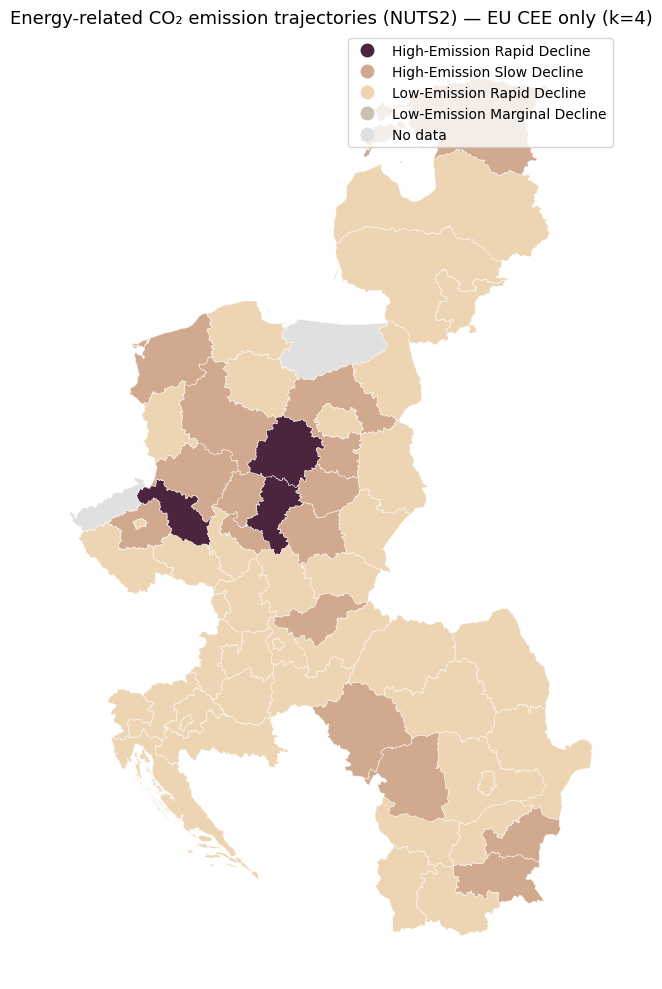

Saved: energy_co2_clusters_k4_map_CEE_EU_custom_colors.png


In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

# -----------------------------
# SETTINGS
# -----------------------------
nuts_path = "Spatial Data/NUTS_RG_01M_2021_4326.shp"

CEE_EU = ["BG", "HR", "CZ", "EE", "HU", "LV", "LT", "PL", "RO", "SI", "SK"]

# Category order (semantic + legend order)
CATEGORY_ORDER = [
    "High-Emission Rapid Decline",
    "High-Emission Slow Decline",
    "Low-Emission Rapid Decline",
    "Low-Emission Marginal Decline",
]

# Exact color palette (your choice) — mapped to new labels
COLOR_MAP = {
    "High-Emission Rapid Decline":   "#4D243D",
    "High-Emission Slow Decline":    "#D0A98F",
    "Low-Emission Rapid Decline":    "#EDD4B2",
    "Low-Emission Marginal Decline": "#CAC2B5",
    "No data":                       "#E0E0E0"
}

# -----------------------------
# 1) Load NUTS shapefile
# -----------------------------
nuts = gpd.read_file(nuts_path)

if "LEVL_CODE" in nuts.columns:
    nuts = nuts[nuts["LEVL_CODE"] == 2].copy()

nuts["NUTS_ID"] = nuts["NUTS_ID"].astype(str)

# -----------------------------
# 2) Filter to EU-CEE countries
# -----------------------------
nuts["country"] = nuts["NUTS_ID"].str[:2]
nuts_cee = nuts[nuts["country"].isin(CEE_EU)].copy()

# -----------------------------
# 3) Merge clustering results
# -----------------------------
# df_features must exist already and include: region, cluster_name
df_features["region"] = df_features["region"].astype(str)
df_features["cluster_name"] = df_features["cluster_name"].astype(str)

gmap = nuts_cee.merge(
    df_features,
    left_on="NUTS_ID",
    right_on="region",
    how="left"
)

# Clean + enforce category order
gmap["cluster_name"] = gmap["cluster_name"].where(
    gmap["cluster_name"].isin(CATEGORY_ORDER),
    other="No data"
)

gmap["cluster_name"] = pd.Categorical(
    gmap["cluster_name"],
    categories=CATEGORY_ORDER + ["No data"],
    ordered=True
)

# -----------------------------
# 4) Build colormap in correct order
# -----------------------------
ordered_colors = [COLOR_MAP[c] for c in CATEGORY_ORDER] + [COLOR_MAP["No data"]]
cmap = ListedColormap(ordered_colors)

# -----------------------------
# 5) Plot
# -----------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gmap.plot(
    column="cluster_name",
    ax=ax,
    cmap=cmap,
    legend=True,
    linewidth=0.3,
    edgecolor="white"
)

ax.set_axis_off()
ax.set_title(
    "Energy-related CO₂ emission trajectories (NUTS2) — EU CEE only (k=4)",
    fontsize=13
)

plt.tight_layout()
plt.savefig(
    "energy_co2_clusters_k4_map_CEE_EU_custom_colors.png",
    dpi=300
)
plt.show()

print("Saved: energy_co2_clusters_k4_map_CEE_EU_custom_colors.png")
